# **Proyecto 3 : Clasificación Multiclase - Glass Classification**
Introducción a Sistemas Inteligentes   2024-II

Gabriela Gallegos Rubio - ggallegosr@unal.edu.co


# Importación de librerías y datos

In [ ]:
from sklearn.ensemble import RandomForestClassifier # SKlearn Random Forest
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler,LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier   # SKlearn KNN
from sklearn.neural_network import MLPClassifier
from sklearn import tree
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from xgboost import XGBClassifier  # XGBoost Classifier
from xgboost import XGBRFClassifier  # XGBoost Random Forest
from imblearn.over_sampling import SMOTE # SMOTE (oversampling)

import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#cargar los .csv desde drive a un dataframe de pandas
original_dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Proyecto 3 SI/glass.csv')

Mounted at /content/drive


# Análisis de datos exploratorio - Preprocesamiento

In [ ]:
#observamos de que consiste el dataset
original_dataframe.describe()
original_dataframe.info()
original_dataframe.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


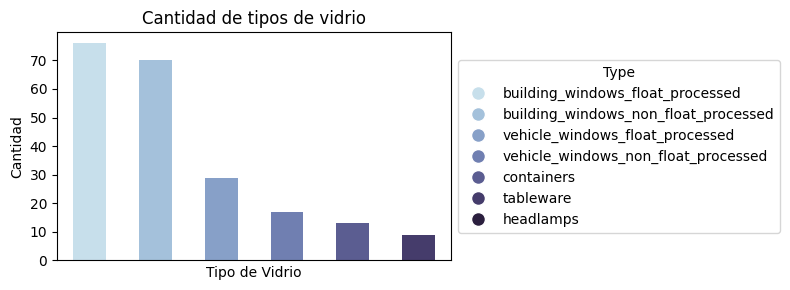

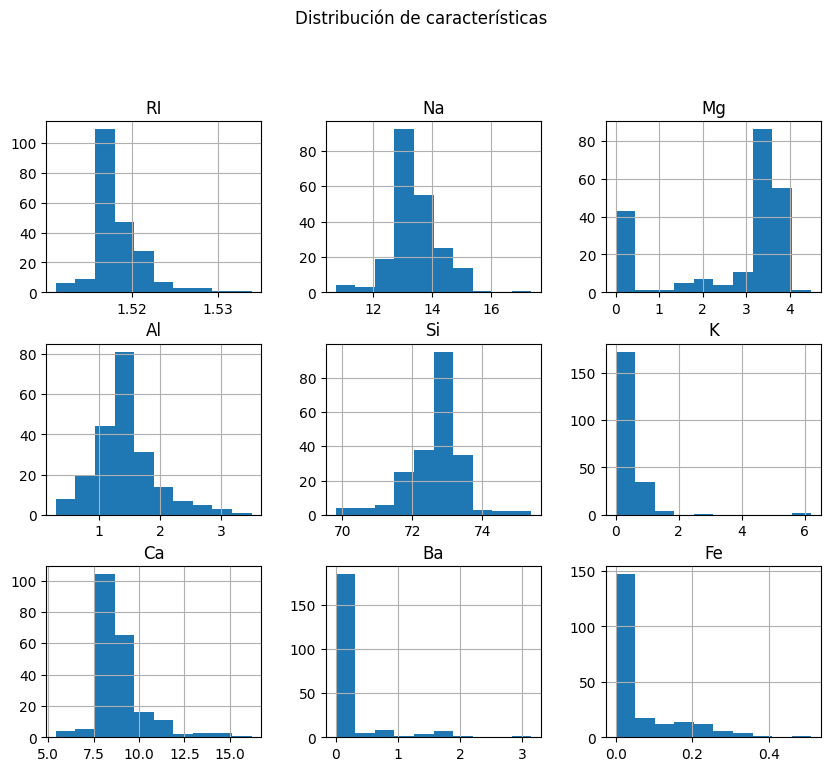

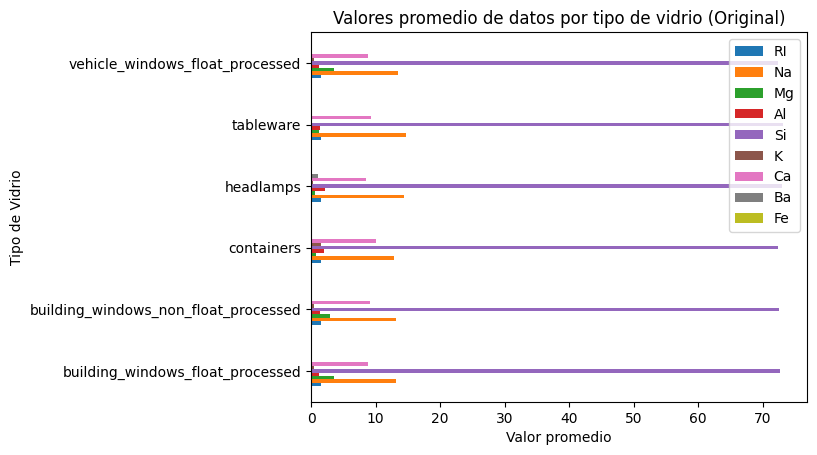

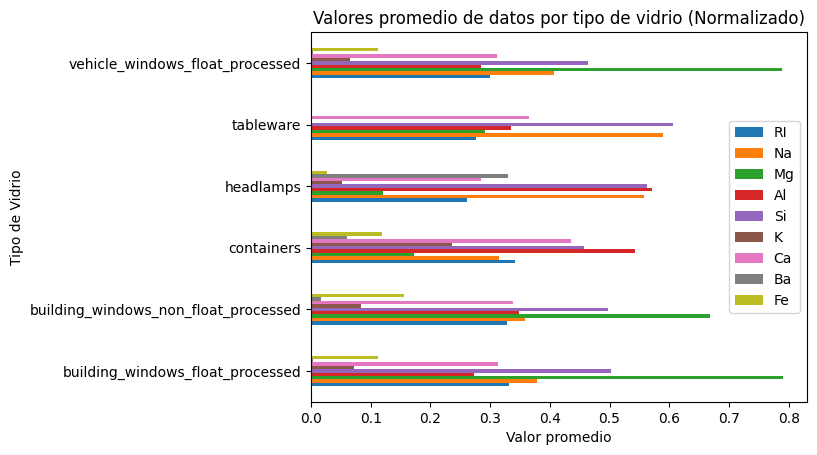

In [ ]:
### Preprocesamiento de Datos

# Copia del DataFrame original
data = original_dataframe.copy()

# 1. Reemplazo de códigos en la columna 'Type'
type_mapping = {
    1: 'building_windows_float_processed',
    2: 'building_windows_non_float_processed',
    3: 'vehicle_windows_float_processed',
    4: 'vehicle_windows_non_float_processed',
    5: 'containers',
    6: 'tableware',
    7: 'headlamps'
}
data['Type'] = data['Type'].replace(type_mapping)

# 2. Visualización de la cantidad de tipos de vidrio con colores segmentados y leyenda
plt.figure(figsize=(8, 3))
colors = sns.color_palette("ch:s=.25,rot=-.25", len(type_mapping))

# Obtener los conteos y crear el gráfico de barras
type_counts = data['Type'].value_counts()
type_counts.plot(kind='bar', color=[colors[i] for i in range(len(type_mapping))])

# Quitar las etiquetas del eje x (solo dejaremos números o nada)
plt.xticks([])  # Esto elimina las etiquetas del eje x

# Añadir título y etiquetas de ejes
plt.title('Cantidad de tipos de vidrio')
plt.xlabel('Tipo de Vidrio')
plt.ylabel('Cantidad')

# Crear una leyenda personalizada con puntos y etiquetas
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor=color, markersize=10)
                   for label, color in zip(type_mapping.values(), colors)]
plt.legend(handles=legend_elements, title='Type', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# 3. Distribución de características
data.hist(figsize=(10, 8))
plt.suptitle('Distribución de características', y=1.02)
plt.show()

# 4. Promedio de cada característica por tipo de vidrio (barras horizontales)
data.groupby('Type').mean().plot(kind='barh')
plt.title('Valores promedio de datos por tipo de vidrio (Original)')
plt.xlabel('Valor promedio')
plt.ylabel('Tipo de Vidrio')
plt.show()

# Normalización (barras horizontales)
numerical_columns = data.select_dtypes(include=np.number).columns.tolist()

data_normalized = data.copy()
data_normalized[numerical_columns] = MinMaxScaler().fit_transform(data[numerical_columns])
data_normalized.groupby('Type').mean().plot(kind='barh')
plt.title('Valores promedio de datos por tipo de vidrio (Normalizado)')
plt.xlabel('Valor promedio')
plt.ylabel('Tipo de Vidrio')
plt.show()

# Obtener la distribución original de las clases
class_counts = data_normalized['Type'].value_counts()
majority_class_count = class_counts.max()  # Número de muestras en la clase mayoritaria

# Crear un diccionario para sampling_strategy: aumentar las clases minoritarias en un 70% (factor 0.7)
# Asegurar que el número objetivo sea mayor que el actual
sampling_strategy = {}
for cls in class_counts.index:
    current_count = class_counts[cls]
    if current_count < majority_class_count:
        target_count = int(majority_class_count * 0.7)
        # Asegurar que el valor objetivo sea mayor que el actual
        if target_count <= current_count:
            target_count = int(current_count * 1.1)  # Aumentar un 10% si es menor o igual
        sampling_strategy[cls] = target_count


# Sobremuestreo (SMOTE) y Outliers

Proporción de varianza explicada: [0.27901819 0.2277858  0.15609378]
Cargas factoriales: [[ 0.54517662 -0.28568318  0.08691083]
 [-0.2581256  -0.27035007 -0.38491962]
 [ 0.11088095  0.59355826  0.00841796]
 [-0.42870863 -0.29521154  0.32923712]
 [-0.22883635  0.15509891 -0.45870884]
 [-0.21934405  0.15397013  0.66257412]
 [ 0.49230609 -0.3453798  -0.00098473]
 [-0.25037512 -0.48470218  0.07405473]
 [ 0.18584154  0.06203879  0.28445055]]


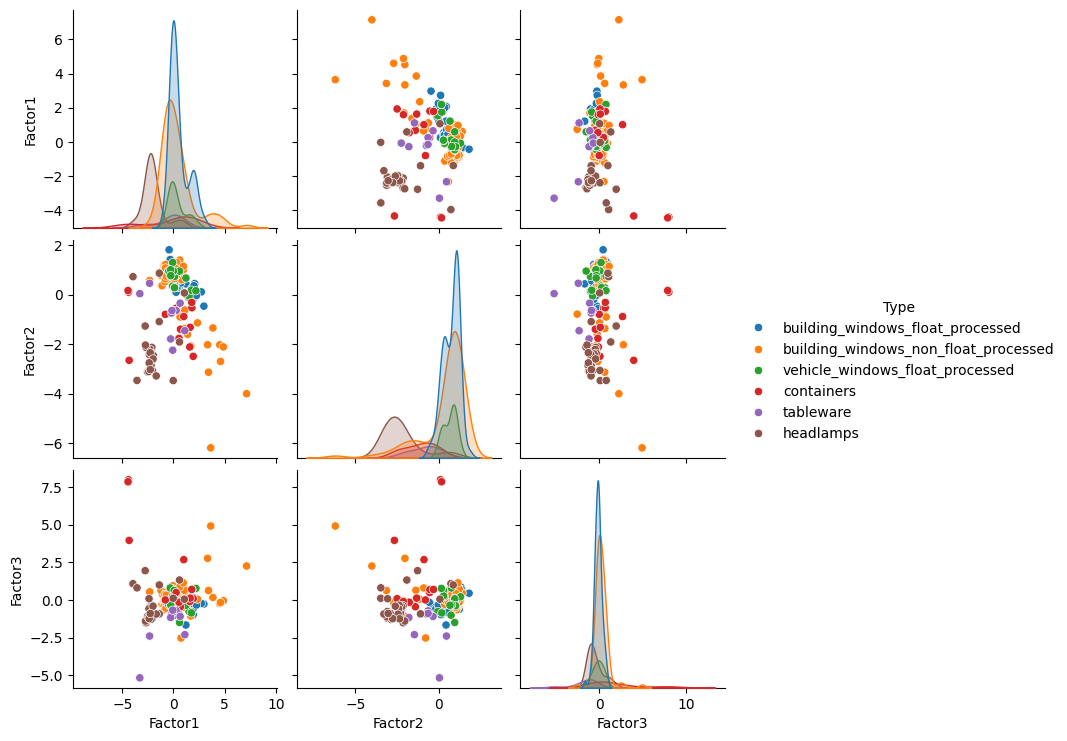

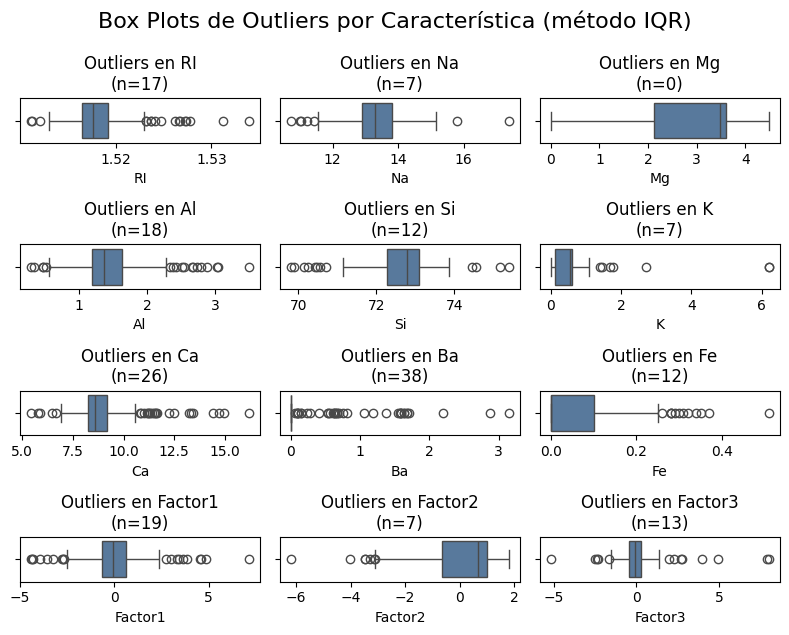

Outliers en RI: 17
Outliers en Na: 7
Outliers en Mg: 0
Outliers en Al: 18
Outliers en Si: 12
Outliers en K: 7
Outliers en Ca: 26
Outliers en Ba: 38
Outliers en Fe: 12
Outliers en Factor1: 19
Outliers en Factor2: 7
Outliers en Factor3: 13


In [ ]:
# Aplicar SMOTE con el nuevo sampling_strategy --- Sobre muestreo
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X = data_normalized[numerical_columns]  # Usar data_normalized para X
y = data_normalized['Type']  # Usar data_normalized para y
X_resampled, y_resampled = smote.fit_resample(X, y)

# Crear el nuevo DataFrame
data_oversampled = pd.DataFrame(X_resampled, columns=numerical_columns)
data_oversampled['Type'] = y_resampled

# Gráfico de promedios con oversampling y normalización
#plt.title('Valores promedio de datos por tipo de vidrio (Normalizado y oversampling)')
#plt.xlabel('Valor promedio')
#plt.ylabel('Tipo de Vidrio')
#plt.show()

# PCA para reducción de dimensionalidad
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Usar X (data_normalized) para PCA

pca = PCA(n_components=3)
pca.fit(X_scaled)

# Obtener la proporción de varianza explicada
explained_variance = pca.explained_variance_ratio_
print("Proporción de varianza explicada:", explained_variance)

# Obtener las cargas factoriales
loadings = pca.components_.T
print("Cargas factoriales:", loadings)

# Obtener las puntuaciones factoriales
factor_scores = pca.transform(X_scaled)

# Añadir las puntuaciones factoriales al dataframe original
data['Factor1'] = factor_scores[:, 0]
data['Factor2'] = factor_scores[:, 1]
data['Factor3'] = factor_scores[:, 2]

sns.pairplot(data, vars=['Factor1', 'Factor2', 'Factor3'], hue='Type')
plt.show()

# Outliers con IQR en una disposición secuencial
# Definir la función detect_outliers_iqr
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Obtener las columnas numéricas
numerical_columns = data.select_dtypes(include=np.number).columns.tolist()

# Outliers con IQR en una disposición secuencial
plt.figure(figsize=(8, 6))  # Ajusta el tamaño de la figura según el número de características

n_cols = 3  # Número de columnas en la cuadrícula
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols  # Calcula el número de filas necesario

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(n_rows, n_cols, i)  # Crea una subgráfica en la posición i
    outliers = detect_outliers_iqr(data, col)
    sns.boxplot(x=data[col], color="#4C78A8")  # Usa un color consistente para uniformidad
    plt.title(f'Outliers en {col}\n(n={len(outliers)})')  # Muestra el número de outliers en el título
    plt.xlabel(col)  # Etiqueta el eje x con el nombre de la característica

plt.tight_layout()  # Ajusta el espaciado para evitar solapamientos
plt.suptitle('Box Plots de Outliers por Característica (método IQR)', y=1.05, fontsize=16)  # Título general
plt.show()

# Imprimir el número de outliers para referencia (opcional)
for col in numerical_columns:
    outliers = detect_outliers_iqr(data, col)
    print(f"Outliers en {col}: {len(outliers)}")

In [ ]:
data_normalized.describe()
data_normalized.info()
data_normalized.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    object 
dtypes: float64(9), object(1)
memory usage: 16.8+ KB


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,0.432836,0.437594,1.000000,0.252336,0.351786,0.009662,0.308550,0.0,0.0,building_windows_float_processed
1,0.283582,0.475188,0.801782,0.333333,0.521429,0.077295,0.223048,0.0,0.0,building_windows_float_processed
2,0.220808,0.421053,0.790646,0.389408,0.567857,0.062802,0.218401,0.0,0.0,building_windows_float_processed
3,0.285777,0.372932,0.821826,0.311526,0.500000,0.091787,0.259294,0.0,0.0,building_windows_float_processed
4,0.275241,0.381955,0.806236,0.295950,0.583929,0.088567,0.245353,0.0,0.0,building_windows_float_processed


In [ ]:
data_oversampled.describe()
data_oversampled.info()
data_oversampled.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      365 non-null    float64
 1   Na      365 non-null    float64
 2   Mg      365 non-null    float64
 3   Al      365 non-null    float64
 4   Si      365 non-null    float64
 5   K       365 non-null    float64
 6   Ca      365 non-null    float64
 7   Ba      365 non-null    float64
 8   Fe      365 non-null    float64
 9   Type    365 non-null    object 
dtypes: float64(9), object(1)
memory usage: 28.6+ KB


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,0.432836,0.437594,1.000000,0.252336,0.351786,0.009662,0.308550,0.0,0.0,building_windows_float_processed
1,0.283582,0.475188,0.801782,0.333333,0.521429,0.077295,0.223048,0.0,0.0,building_windows_float_processed
2,0.220808,0.421053,0.790646,0.389408,0.567857,0.062802,0.218401,0.0,0.0,building_windows_float_processed
3,0.285777,0.372932,0.821826,0.311526,0.500000,0.091787,0.259294,0.0,0.0,building_windows_float_processed
4,0.275241,0.381955,0.806236,0.295950,0.583929,0.088567,0.245353,0.0,0.0,building_windows_float_processed


# Análisis de Correlación

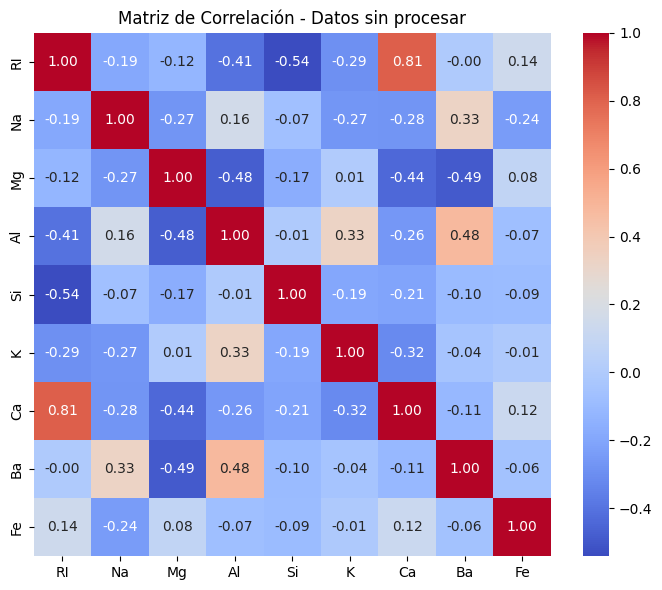

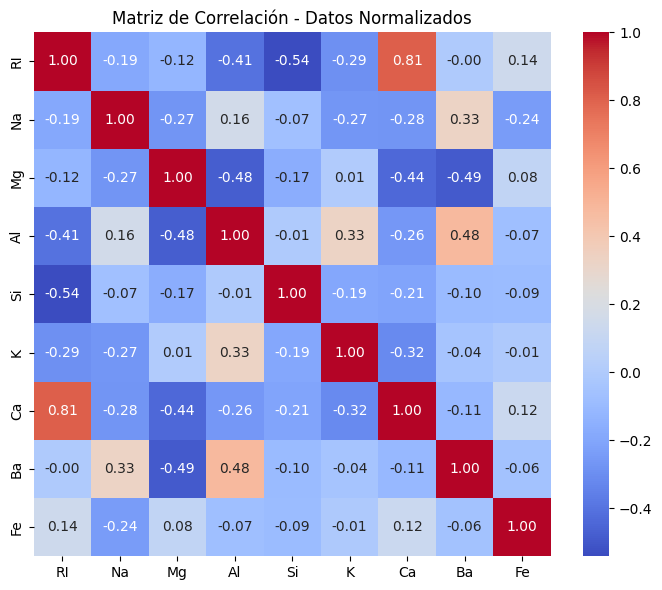

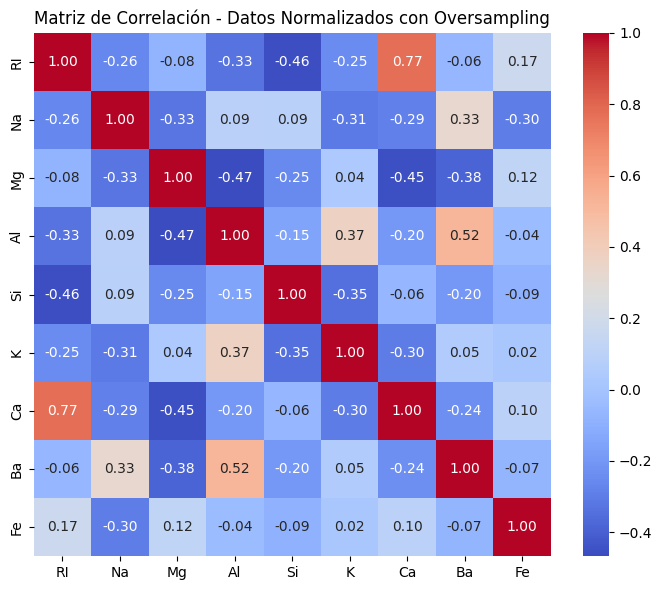

In [ ]:
# Ajuste y generacón del heatmap - matriz

def plot_heatmap(df, title):

    numeric_df = df.select_dtypes(include=['number']).copy() # Solo col numericas

    # Eliminar los Factores por lo que ya se realizó el PCA
    for factor in ['Factor1', 'Factor2', 'Factor3']:
        if factor in numeric_df.columns:
            numeric_df.drop(columns=factor, inplace=True)


    plt.figure(figsize=(7, 6))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_heatmap(data, 'Matriz de Correlación - Datos sin procesar')

plot_heatmap(data_normalized, 'Matriz de Correlación - Datos Normalizados')

plot_heatmap(data_oversampled, 'Matriz de Correlación - Datos Normalizados con Oversampling')

# Se evidencia en las Matrices de Correlación que la Normalización de los Datos no afecta las relaciones o dependencias entre características


# **Técnicas de Clasificación**

# Árbol de decisión simple



Datos sin procesar - Estimación max_depth: 7
Datos sin procesar - Estimación min_samples_split: 2
Datos sin procesar - Estimación min_samples_leaf: 21

Datos sin procesar - Classification Report:
                                       precision    recall  f1-score   support

    building_windows_float_processed       0.65      0.62      0.63        21
building_windows_non_float_processed       0.56      0.83      0.67        23
                          containers       0.00      0.00      0.00         4
                           headlamps       0.82      1.00      0.90         9
                           tableware       0.00      0.00      0.00         3
     vehicle_windows_float_processed       0.00      0.00      0.00         5

                            accuracy                           0.63        65
                           macro avg       0.34      0.41      0.37        65
                        weighted avg       0.52      0.63      0.57        65



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


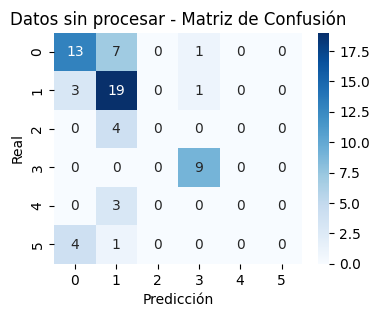


Datos normalizados - Estimación max_depth: 7
Datos normalizados - Estimación min_samples_split: 2
Datos normalizados - Estimación min_samples_leaf: 21

Datos normalizados - Classification Report:
                                       precision    recall  f1-score   support

    building_windows_float_processed       0.65      0.62      0.63        21
building_windows_non_float_processed       0.56      0.83      0.67        23
                          containers       0.00      0.00      0.00         4
                           headlamps       0.82      1.00      0.90         9
                           tableware       0.00      0.00      0.00         3
     vehicle_windows_float_processed       0.00      0.00      0.00         5

                            accuracy                           0.63        65
                           macro avg       0.34      0.41      0.37        65
                        weighted avg       0.52      0.63      0.57        65



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


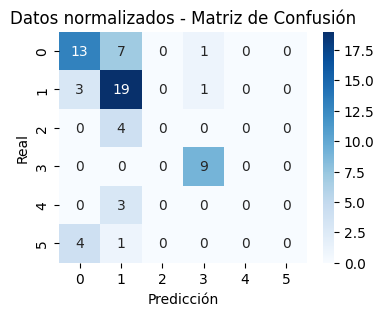


Datos con Oversampling - Estimación max_depth: 8
Datos con Oversampling - Estimación min_samples_split: 3
Datos con Oversampling - Estimación min_samples_leaf: 36

Datos con Oversampling - Classification Report:
                                       precision    recall  f1-score   support

    building_windows_float_processed       0.63      0.52      0.57        23
building_windows_non_float_processed       0.71      0.52      0.60        23
                          containers       0.75      0.75      0.75        16
                           headlamps       0.75      0.75      0.75        16
                           tableware       0.89      1.00      0.94        16
     vehicle_windows_float_processed       0.50      0.75      0.60        16

                            accuracy                           0.69       110
                           macro avg       0.70      0.72      0.70       110
                        weighted avg       0.70      0.69      0.69       110



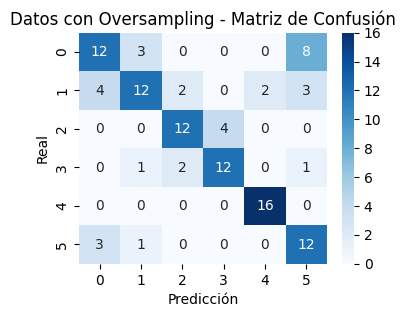

In [ ]:
def decision_tree_model(model_data, dataset_name):
    # Calcular hiperparámetros
    N = len(model_data)
    max_depth_est = int(np.log2(N))
    min_samples_split_est = max(2, N // 100)
    min_samples_leaf_est = max(1, N // 10)

    print(f"\n{dataset_name} - Estimación max_depth: {max_depth_est}")
    print(f"{dataset_name} - Estimación min_samples_split: {min_samples_split_est}")
    print(f"{dataset_name} - Estimación min_samples_leaf: {min_samples_leaf_est}")

    X = model_data.drop(columns="Type")
    y = model_data["Type"]

    # División de datos
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Crear y entrenar el modelo
    model = DecisionTreeClassifier(
        max_depth=max_depth_est,
        min_samples_split=min_samples_split_est,
        min_samples_leaf=min_samples_leaf_est,
        random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    # Matriz de Confusión
    cm = confusion_matrix(y_val, y_pred)

    print(f"\n{dataset_name} - Classification Report:\n", classification_report(y_val, y_pred))

    # Visualización de la Matriz de Confusión
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"{dataset_name} - Matriz de Confusión")
    plt.show()

# Evaluar Árbol de Decisión para los tres conjuntos de datos
decision_tree_model(data, "Datos sin procesar")
decision_tree_model(data_normalized, "Datos normalizados")
decision_tree_model(data_oversampled, "Datos con Oversampling")


# Random Forest - Sklearn



Datos sin procesar - Mejor Configuración de Hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}

Datos sin procesar - Classification Report:
                                       precision    recall  f1-score   support

    building_windows_float_processed       0.74      0.81      0.77        21
building_windows_non_float_processed       0.86      0.78      0.82        23
                          containers       0.75      0.75      0.75         4
                           headlamps       1.00      1.00      1.00         9
                           tableware       0.75      1.00      0.86         3
     vehicle_windows_float_processed       0.50      0.40      0.44         5

                            accuracy                           0.80        65
                           macro avg       0.77      0.79      0.77        65
                        weighted avg       0.80      0.80      0.80        65



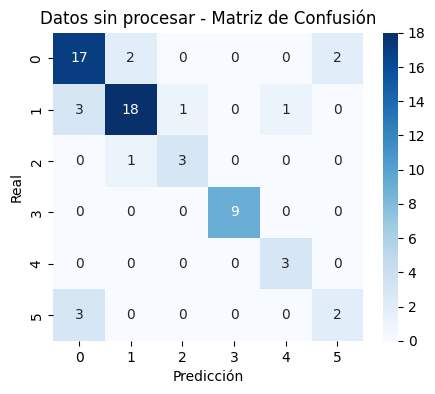


Datos normalizados - Mejor Configuración de Hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Datos normalizados - Classification Report:
                                       precision    recall  f1-score   support

    building_windows_float_processed       0.86      0.90      0.88        21
building_windows_non_float_processed       0.90      0.83      0.86        23
                          containers       0.60      0.75      0.67         4
                           headlamps       1.00      1.00      1.00         9
                           tableware       0.75      1.00      0.86         3
     vehicle_windows_float_processed       0.75      0.60      0.67         5

                            accuracy                           0.86        65
                           macro avg       0.81      0.85      0.82        65
                        weighted avg       0.87      0.86      0.86        65



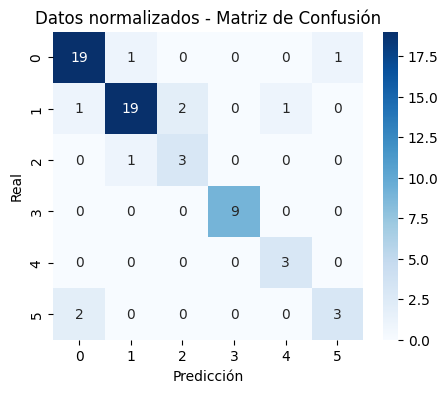


Datos con Oversampling - Mejor Configuración de Hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}

Datos con Oversampling - Classification Report:
                                       precision    recall  f1-score   support

    building_windows_float_processed       0.90      0.83      0.86        23
building_windows_non_float_processed       0.90      0.83      0.86        23
                          containers       0.88      0.88      0.88        16
                           headlamps       0.87      0.81      0.84        16
                           tableware       1.00      1.00      1.00        16
     vehicle_windows_float_processed       0.76      1.00      0.86        16

                            accuracy                           0.88       110
                           macro avg       0.89      0.89      0.88       110
                        weighted avg       0.89      0.88      0.88       110



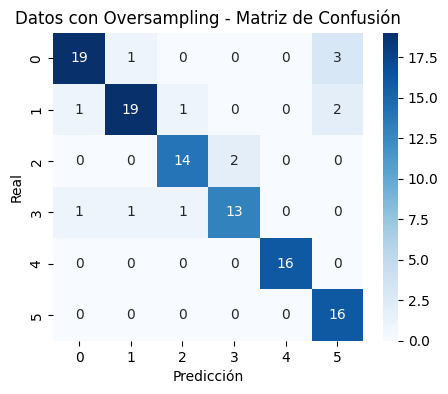

In [ ]:
def random_forest_model(model_data, dataset_name):
    X = model_data.drop(columns="Type")
    y = model_data["Type"]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 3, 5],
        'min_samples_leaf': [1, 2, 4]
    }

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)

    print(f"\n{dataset_name} - Mejor Configuración de Hiperparámetros:", grid_search.best_params_)
    print(f"\n{dataset_name} - Classification Report:\n", classification_report(y_val, y_pred))

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"{dataset_name} - Matriz de Confusión")
    plt.show()

# Evaluar Random Forest para los tres conjuntos de datos
random_forest_model(data, "Datos sin procesar")
random_forest_model(data_normalized, "Datos normalizados")
random_forest_model(data_oversampled, "Datos con Oversampling")


# Random Forest - XGBoost


Datos sin procesar - Mejor Configuración de Hiperparámetros: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}

Datos sin procesar - Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84        21
           1       0.86      0.78      0.82        23
           2       0.80      1.00      0.89         4
           3       0.90      1.00      0.95         9
           4       0.75      1.00      0.86         3
           5       1.00      0.20      0.33         5

    accuracy                           0.83        65
   macro avg       0.85      0.81      0.78        65
weighted avg       0.84      0.83      0.81        65



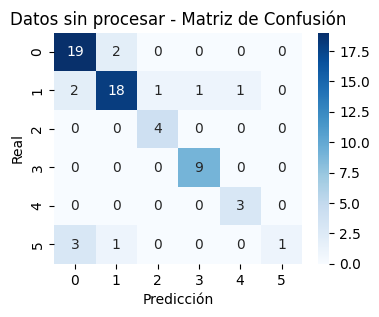


Datos normalizados - Mejor Configuración de Hiperparámetros: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}

Datos normalizados - Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84        21
           1       0.86      0.78      0.82        23
           2       0.80      1.00      0.89         4
           3       0.90      1.00      0.95         9
           4       0.75      1.00      0.86         3
           5       1.00      0.20      0.33         5

    accuracy                           0.83        65
   macro avg       0.85      0.81      0.78        65
weighted avg       0.84      0.83      0.81        65



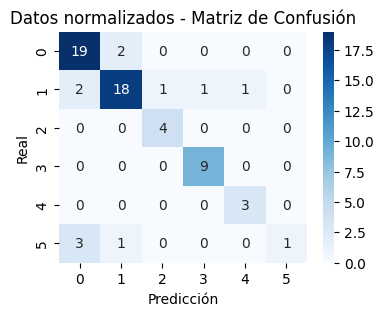


Datos con Oversampling - Mejor Configuración de Hiperparámetros: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100}

Datos con Oversampling - Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83        23
           1       0.77      0.74      0.76        23
           2       0.80      0.75      0.77        16
           3       0.87      0.81      0.84        16
           4       1.00      1.00      1.00        16
           5       0.79      0.94      0.86        16

    accuracy                           0.84       110
   macro avg       0.84      0.84      0.84       110
weighted avg       0.84      0.84      0.84       110



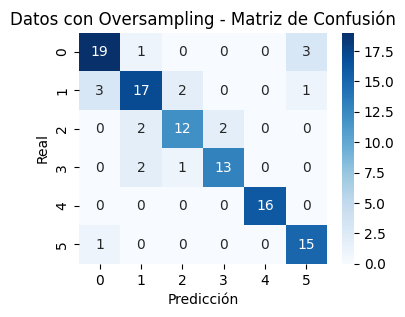

In [30]:
def xgboost_model(model_data, dataset_name):
    X = model_data.drop(columns="Type")
    y = model_data["Type"]

    label_encoder = LabelEncoder()

    if not np.issubdtype(y.dtype, np.integer):
        y = LabelEncoder().fit_transform(y)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 10],
        'learning_rate': [0.01, 0.1, 0.2]
    }

    xgb = XGBRFClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)

    print(f"\n{dataset_name} - Mejor Configuración de Hiperparámetros:", grid_search.best_params_)
    print(f"\n{dataset_name} - Classification Report:\n", classification_report(y_val, y_pred))

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"{dataset_name} - Matriz de Confusión")
    plt.show()

# Evaluar XGBoost para los tres conjuntos de datos
xgboost_model(data, "Datos sin procesar")
xgboost_model(data_normalized, "Datos normalizados")
xgboost_model(data_oversampled, "Datos con Oversampling")




Datos sin procesar - Mejor Configuración de Hiperparámetros: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}

Datos sin procesar - Classification Report:
                                       precision    recall  f1-score   support

    building_windows_float_processed       0.79      0.90      0.84        21
building_windows_non_float_processed       0.86      0.78      0.82        23
                          containers       0.80      1.00      0.89         4
                           headlamps       0.90      1.00      0.95         9
                           tableware       0.75      1.00      0.86         3
     vehicle_windows_float_processed       1.00      0.20      0.33         5

                            accuracy                           0.83        65
                           macro avg       0.85      0.81      0.78        65
                        weighted avg       0.84      0.83      0.81        65



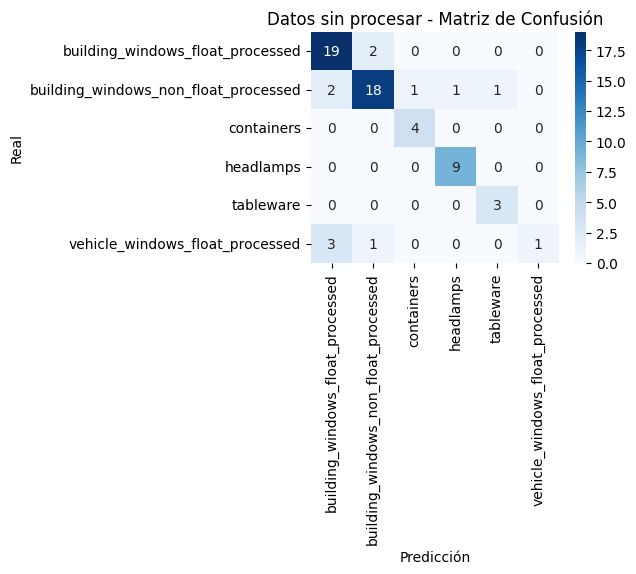


Datos normalizados - Mejor Configuración de Hiperparámetros: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}

Datos normalizados - Classification Report:
                                       precision    recall  f1-score   support

    building_windows_float_processed       0.79      0.90      0.84        21
building_windows_non_float_processed       0.86      0.78      0.82        23
                          containers       0.80      1.00      0.89         4
                           headlamps       0.90      1.00      0.95         9
                           tableware       0.75      1.00      0.86         3
     vehicle_windows_float_processed       1.00      0.20      0.33         5

                            accuracy                           0.83        65
                           macro avg       0.85      0.81      0.78        65
                        weighted avg       0.84      0.83      0.81        65



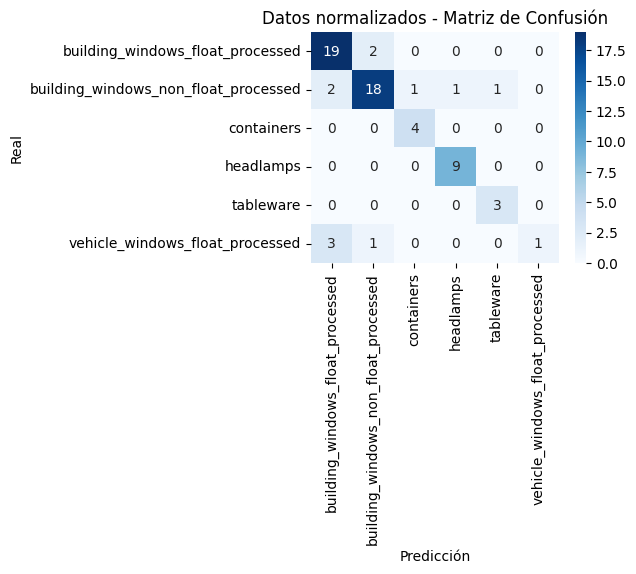


Datos con Oversampling - Mejor Configuración de Hiperparámetros: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100}

Datos con Oversampling - Classification Report:
                                       precision    recall  f1-score   support

    building_windows_float_processed       0.83      0.83      0.83        23
building_windows_non_float_processed       0.77      0.74      0.76        23
                          containers       0.80      0.75      0.77        16
                           headlamps       0.87      0.81      0.84        16
                           tableware       1.00      1.00      1.00        16
     vehicle_windows_float_processed       0.79      0.94      0.86        16

                            accuracy                           0.84       110
                           macro avg       0.84      0.84      0.84       110
                        weighted avg       0.84      0.84      0.84       110



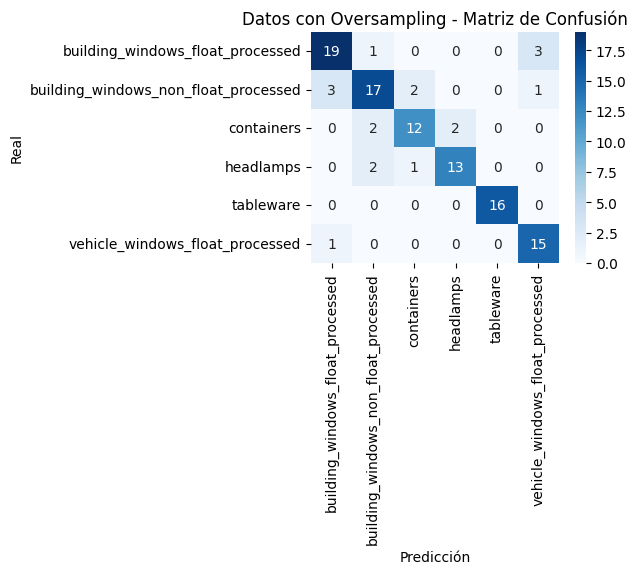

In [31]:
def xgboost_model(model_data, dataset_name):
    X = model_data.drop(columns="Type")
    y = model_data["Type"]

    label_encoder = LabelEncoder()
    if not np.issubdtype(y.dtype, np.integer):
        y = label_encoder.fit_transform(y)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 10],
        'learning_rate': [0.01, 0.1, 0.2]
    }

    xgb = XGBRFClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)

    print(f"\n{dataset_name} - Mejor Configuración de Hiperparámetros:", grid_search.best_params_)
    print(f"\n{dataset_name} - Classification Report:\n", classification_report(y_val, y_pred, target_names=label_encoder.classes_))

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"{dataset_name} - Matriz de Confusión")
    plt.show()

# Evaluar XGBoost para los tres conjuntos de datos
xgboost_model(data, "Datos sin procesar")
xgboost_model(data_normalized, "Datos normalizados")
xgboost_model(data_oversampled, "Datos con Oversampling")


#Red neuronal

Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and be

Datos sin procesar - Mejores Parámetros:  {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
Datos sin procesar - Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.91      0.77        11
           1       0.71      0.71      0.71        14
           2       1.00      0.75      0.86         4
           3       0.89      1.00      0.94         8
           4       1.00      0.67      0.80         3
           5       0.00      0.00      0.00         3

    accuracy                           0.77        43
   macro avg       0.71      0.67      0.68        43
weighted avg       0.73      0.77      0.74        43



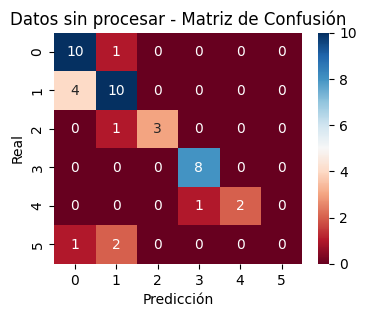

Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and be

Datos normalizados - Mejores Parámetros:  {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
Datos normalizados - Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.91      0.77        11
           1       0.71      0.71      0.71        14
           2       1.00      0.75      0.86         4
           3       0.89      1.00      0.94         8
           4       1.00      0.67      0.80         3
           5       0.00      0.00      0.00         3

    accuracy                           0.77        43
   macro avg       0.71      0.67      0.68        43
weighted avg       0.73      0.77      0.74        43



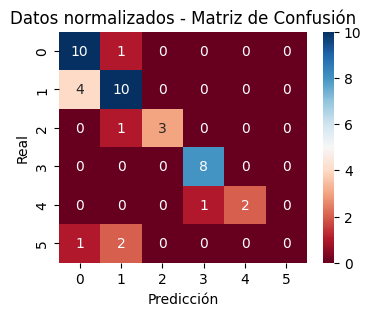

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Datos con Oversampling - Mejores Parámetros:  {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant'}
Datos con Oversampling - Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.72      0.81        18
           1       0.81      0.76      0.79        17
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         9
           4       0.89      1.00      0.94         8
           5       0.76      1.00      0.87        13

    accuracy                           0.88        73
   macro avg       0.90      0.91      0.90        73
weighted avg       0.88      0.88      0.87        73



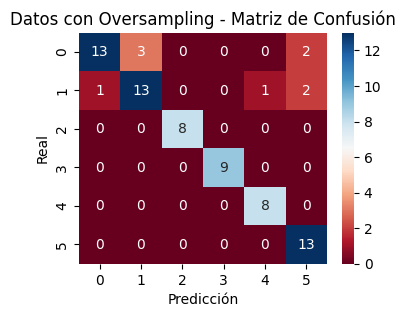

In [32]:
def mpl_model(model_data, dataset_name):
    X = model_data.drop(columns="Type")
    y = model_data["Type"]

    if not np.issubdtype(y.dtype, np.integer):
        y = LabelEncoder().fit_transform(y)

    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize Data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define MLP Classifier
    mlp = MLPClassifier(max_iter=1000, random_state=42)

    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'logistic'],
        'alpha': [0.0001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }

    grid_search = GridSearchCV(mlp, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
    grid_search.fit(X_train_scaled, y_train)

    print(f"{dataset_name} - Mejores Parámetros: ", grid_search.best_params_)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)

    print(f"{dataset_name} - Classification Report:\n", classification_report(y_test, y_pred))

    # Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="RdBu")
    plt.title(f"{dataset_name} - Matriz de Confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()


mpl_model(data, "Datos sin procesar")
mpl_model(data_normalized, "Datos normalizados")
mpl_model(data_oversampled, "Datos con Oversampling")

# K- Nearest Neighbors


Datos sin procesar - Mejor Configuración de Hiperparámetros: {'n_neighbors': 5, 'weights': 'distance'}

Datos sin procesar - Classification Report:
                                       precision    recall  f1-score   support

    building_windows_float_processed       0.62      0.73      0.67        11
building_windows_non_float_processed       0.62      0.71      0.67        14
                          containers       0.75      0.75      0.75         4
                           headlamps       1.00      0.88      0.93         8
                           tableware       0.67      0.67      0.67         3
     vehicle_windows_float_processed       0.00      0.00      0.00         3

                            accuracy                           0.70        43
                           macro avg       0.61      0.62      0.61        43
                        weighted avg       0.66      0.70      0.68        43



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


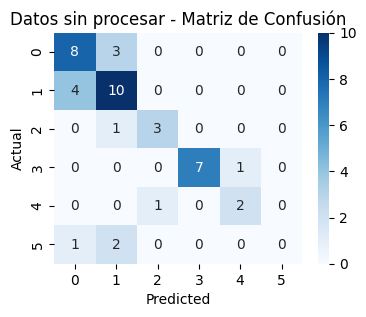


Datos normalizados - Mejor Configuración de Hiperparámetros: {'n_neighbors': 5, 'weights': 'distance'}

Datos normalizados - Classification Report:
                                       precision    recall  f1-score   support

    building_windows_float_processed       0.62      0.73      0.67        11
building_windows_non_float_processed       0.62      0.71      0.67        14
                          containers       0.75      0.75      0.75         4
                           headlamps       1.00      0.88      0.93         8
                           tableware       0.67      0.67      0.67         3
     vehicle_windows_float_processed       0.00      0.00      0.00         3

                            accuracy                           0.70        43
                           macro avg       0.61      0.62      0.61        43
                        weighted avg       0.66      0.70      0.68        43



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


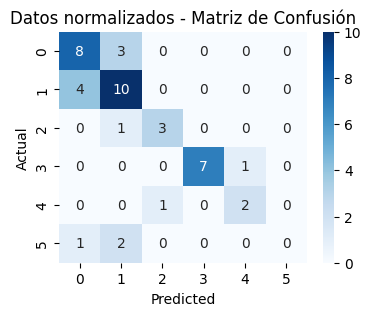


Datos con Oversampling - Mejor Configuración de Hiperparámetros: {'n_neighbors': 3, 'weights': 'distance'}

Datos con Oversampling - Classification Report:
                                       precision    recall  f1-score   support

    building_windows_float_processed       0.91      0.56      0.69        18
building_windows_non_float_processed       0.65      0.65      0.65        17
                          containers       0.80      1.00      0.89         8
                           headlamps       0.90      1.00      0.95         9
                           tableware       1.00      1.00      1.00         8
     vehicle_windows_float_processed       0.71      0.92      0.80        13

                            accuracy                           0.79        73
                           macro avg       0.83      0.85      0.83        73
                        weighted avg       0.81      0.79      0.79        73



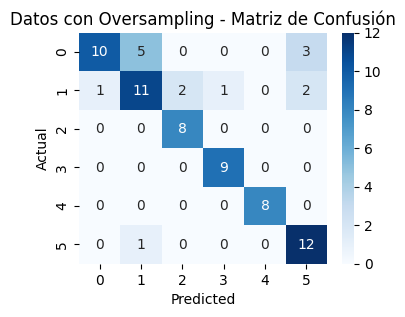

In [34]:
def knn_model(model_data, dataset_name):
    X = model_data.drop(columns="Type")
    y = model_data["Type"]

    # Label Encoder
    label_encoder = LabelEncoder()
    if not np.issubdtype(y.dtype, np.integer):
        y = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    param_grid = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X_train_scaled, y_train)

    print(f"\n{dataset_name} - Mejor Configuración de Hiperparámetros:", grid_search.best_params_)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n{dataset_name} - Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{dataset_name} - Matriz de Confusión")
    plt.show()

# Evaluar los modelos
knn_model(data, "Datos sin procesar")
knn_model(data_normalized, "Datos normalizados")
knn_model(data_oversampled, "Datos con Oversampling")


# Classifier XGBoost

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:15:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Datos sin procesar - Classification Report:
                                       precision    recall  f1-score   support

    building_windows_float_processed       0.83      0.91      0.87        11
building_windows_non_float_processed       0.85      0.79      0.81        14
                          containers       0.50      0.50      0.50         4
                           headlamps       0.89      1.00      0.94         8
                           tableware       1.00      1.00      1.00         3
     vehicle_windows_float_processed       1.00      0.67      0.80         3

                            accuracy                           0.84        43
                           macro avg       0.84      0.81      0.82        43
                        weighted avg       0.84      0.84      0.83        43



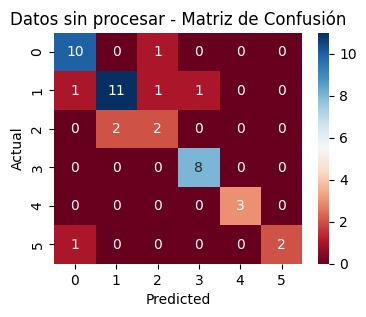

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:15:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Datos normalizados - Classification Report:
                                       precision    recall  f1-score   support

    building_windows_float_processed       0.83      0.91      0.87        11
building_windows_non_float_processed       0.85      0.79      0.81        14
                          containers       0.50      0.50      0.50         4
                           headlamps       0.89      1.00      0.94         8
                           tableware       1.00      1.00      1.00         3
     vehicle_windows_float_processed       1.00      0.67      0.80         3

                            accuracy                           0.84        43
                           macro avg       0.84      0.81      0.82        43
                        weighted avg       0.84      0.84      0.83        43



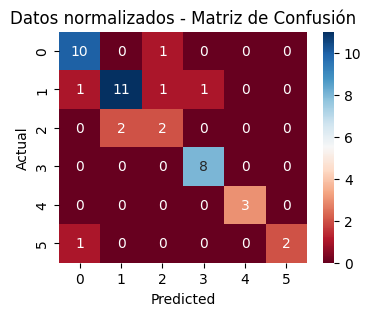

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:15:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Datos con Oversampling - Classification Report:
                                       precision    recall  f1-score   support

    building_windows_float_processed       0.88      0.78      0.82        18
building_windows_non_float_processed       0.76      0.76      0.76        17
                          containers       0.80      1.00      0.89         8
                           headlamps       1.00      0.89      0.94         9
                           tableware       0.89      1.00      0.94         8
     vehicle_windows_float_processed       0.92      0.92      0.92        13

                            accuracy                           0.86        73
                           macro avg       0.88      0.89      0.88        73
                        weighted avg       0.87      0.86      0.86        73



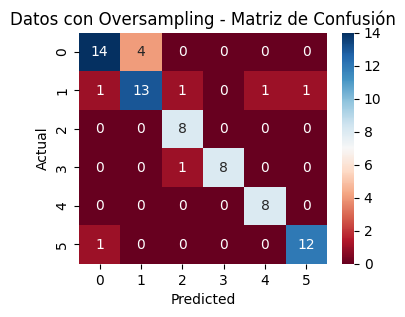

In [35]:
def xgb_model(model_data, dataset_name):
    X = model_data.drop(columns="Type")
    y = model_data["Type"]

    # Label Encoder
    label_encoder = LabelEncoder()
    if not np.issubdtype(y.dtype, np.integer):
        y = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print(f"\n{dataset_name} - Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="RdBu")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{dataset_name} - Matriz de Confusión")
    plt.show()

# Evaluar los modelos
xgb_model(data, "Datos sin procesar")
xgb_model(data_normalized, "Datos normalizados")
xgb_model(data_oversampled, "Datos con Oversampling")


# CatBoost

In [36]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00



Datos sin procesar - Classification Report:
                                       precision    recall  f1-score   support

    building_windows_float_processed       0.85      1.00      0.92        11
building_windows_non_float_processed       0.92      0.79      0.85        14
                          containers       0.60      0.75      0.67         4
                           headlamps       1.00      1.00      1.00         8
                           tableware       1.00      1.00      1.00         3
     vehicle_windows_float_processed       1.00      0.67      0.80         3

                            accuracy                           0.88        43
                           macro avg       0.89      0.87      0.87        43
                        weighted avg       0.90      0.88      0.88        43



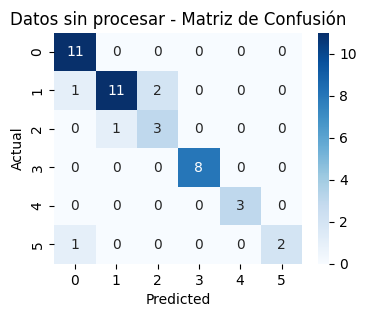


Datos normalizados - Classification Report:
                                       precision    recall  f1-score   support

    building_windows_float_processed       0.85      1.00      0.92        11
building_windows_non_float_processed       0.92      0.86      0.89        14
                          containers       0.75      0.75      0.75         4
                           headlamps       1.00      1.00      1.00         8
                           tableware       1.00      1.00      1.00         3
     vehicle_windows_float_processed       1.00      0.67      0.80         3

                            accuracy                           0.91        43
                           macro avg       0.92      0.88      0.89        43
                        weighted avg       0.91      0.91      0.91        43



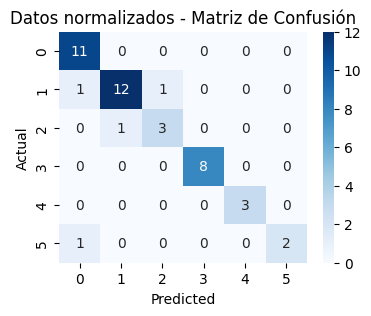


Datos con Oversampling - Classification Report:
                                       precision    recall  f1-score   support

    building_windows_float_processed       0.84      0.89      0.86        18
building_windows_non_float_processed       0.85      0.65      0.73        17
                          containers       0.89      1.00      0.94         8
                           headlamps       1.00      1.00      1.00         9
                           tableware       0.80      1.00      0.89         8
     vehicle_windows_float_processed       0.92      0.92      0.92        13

                            accuracy                           0.88        73
                           macro avg       0.88      0.91      0.89        73
                        weighted avg       0.88      0.88      0.87        73



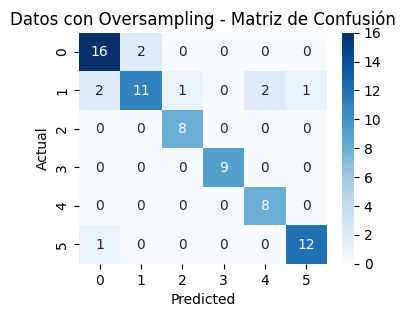

In [37]:
from catboost import CatBoostClassifier

def catboost_model(model_data, dataset_name):
    X = model_data.drop(columns="Type")
    y = model_data["Type"]

    # Label Encoder
    label_encoder = LabelEncoder()
    if not np.issubdtype(y.dtype, np.integer):
        y = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modelo CatBoost
    model = CatBoostClassifier(iterations=200, depth=6, learning_rate=0.1, verbose=0)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print(f"\n{dataset_name} - Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{dataset_name} - Matriz de Confusión")
    plt.show()

# Evaluación con los tres datasets
catboost_model(data, "Datos sin procesar")
catboost_model(data_normalized, "Datos normalizados")
catboost_model(data_oversampled, "Datos con Oversampling")
